In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-in-india/ICMRTestingDetails.csv
/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv
/kaggle/input/covid19-in-india/HospitalBedsIndia.csv
/kaggle/input/covid19-in-india/covid_19_india.csv
/kaggle/input/covid19-in-india/population_india_census2011.csv
/kaggle/input/covid19-in-india/ICMRTestingLabs.csv
/kaggle/input/covid19-in-india/IndividualDetails.csv
/kaggle/input/covid19-in-india/AgeGroupDetails.csv
/kaggle/input/corona-virus-report/tests.csv
/kaggle/input/corona-virus-report/covid_19_clean_complete.csv
/kaggle/input/corona-virus-report/usa_county_wise.csv
/kaggle/input/utm-of-india/UTM ZONES of INDIA.csv
/kaggle/input/countrydatafile/Global_Data_by_Country_2019.csv
/kaggle/input/countrydatafile/coordinates.csv
/kaggle/input/covid19all1/covid-19-all.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

import math
import bokeh
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.request import urlopen
import json
from dateutil import parser
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import row, column
from bokeh.resources import INLINE
from bokeh.io import output_notebook
from bokeh.models import Span
import warnings
from datetime import date
import scipy
warnings.filterwarnings("ignore")
output_notebook(resources=INLINE)

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures

Loading BokehJS ...

# Tree plot India

In [3]:
covid_India_cases = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
covid_India_cases.rename(columns={'State/UnionTerritory': 'State', 'Cured': 'Recovered', 'Confirmed': 'Confirmed'}, inplace=True)
statewise_cases = pd.DataFrame(covid_India_cases.groupby(['State'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index())
statewise_cases["Country"] = "India"
fig = px.treemap(statewise_cases, path=['Country','State'], values='Confirmed',
                  color='Confirmed', hover_data=['State'],
                  color_continuous_scale='Rainbow')

fig.show()

# **Map View**

In [4]:
positions = pd.read_csv('../input/utm-of-india/UTM ZONES of INDIA.csv')
ind_grp=statewise_cases.merge(positions , left_on='State', right_on='State / Union Territory')

In [5]:
import folium
map = folium.Map(location=[20.5937, 78.9629], zoom_start=4,tiles='Stamen Toner')
for lat, lon,state,Confirmed,Recovered,Deaths in zip(ind_grp['Latitude'], ind_grp['Longitude'],ind_grp['State'],ind_grp['Confirmed'],ind_grp['Recovered'],ind_grp['Deaths']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =(
                    'State: ' + str(state) + '<br>'
                    'Confirmed: ' + str(Confirmed) + '<br>'
                      'Recovered: ' + str(Recovered) + '<br>'
                      'Deaths: ' + str(Deaths) + '<br>'),

                        fill_color='red',
                        fill_opacity=0.7 ).add_to(map)
map

In [6]:
ind_map = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
pos = pd.read_csv('../input/utm-of-india/UTM ZONES of INDIA.csv')
ind_map = ind_map.merge(pos , left_on='State/UnionTerritory', right_on='State / Union Territory')
ind_map  = ind_map.groupby(['Date', 'State/UnionTerritory','Latitude','Longitude'])['Confirmed'].sum().reset_index()
#ind_map.head()

In [7]:
ind_map['size'] = ind_map['Confirmed']*100000000

fig = px.scatter_mapbox(ind_map, lat="Latitude", lon="Longitude",
                     color="Confirmed", size='size',hover_data=['State/UnionTerritory'],
                     color_continuous_scale='burgyl', animation_frame="Date", 
                     title='Spread total cases over time in India')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=3, mapbox_center = {"lat":20.5937,"lon":78.9629})
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

# Indian Subcontinent Visualization

In [8]:
train1 = pd.read_csv('../input/countrydatafile/coordinates.csv',parse_dates=['Date'])
train1['Province/State'] = train1['Province/State'].fillna('')
temp = train1[[col for col in train1.columns if col != 'Province/State']]

latest = temp[temp['Date'] == max(temp['Date'])].reset_index()
latest_grouped = latest.groupby('Country/Region')['ConfirmedCases', 'Fatalities'].sum().reset_index()

In [9]:
indiansubcon = list(['India','Pakistan','Bangladesh','Nepal','Sri Lanka','Bhutan','Maldives'])
insubc_latest_grouped = latest_grouped[latest_grouped['Country/Region'].isin(indiansubcon)]

In [10]:
fig = px.choropleth(insubc_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color="ConfirmedCases", 
                    hover_name="Country/Region", range_color=[1,2000], 
                    color_continuous_scale='portland', 
                    title='Indian Subcontinent Countries with Confirmed Cases', scope='asia', height=800)
fig.show()

In [11]:
age_details = pd.read_csv('../input/covid19-in-india/AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
hospital_beds = pd.read_csv('../input/covid19-in-india/HospitalBedsIndia.csv')
individual_details = pd.read_csv('../input/covid19-in-india/IndividualDetails.csv')
ICMR_details = pd.read_csv('../input/covid19-in-india/ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('../input/covid19-in-india/ICMRTestingLabs.csv')
state_testing = pd.read_csv('../input/covid19-in-india/StatewiseTestingDetails.csv')

# **Pie Chart of Confirmed Cases in India**

In [12]:
fig = px.pie(age_details, values="TotalCases", names="AgeGroup",title='Confirmed cases of India')
fig.show()

# Gender Visualization

([<matplotlib.patches.Wedge at 0x7f7a287fa6d0>,
 [Text(-0.6197155099648909, -0.908819391688445, 'Missing'),
  Text(0.8586462342722834, 0.8382879245044791, 'Male'),
  Text(0.21737865020854588, 1.0783072486232812, 'Female')],
 [Text(-0.33802664179903136, -0.4957196681936972, '81.0%'),
  Text(0.5008769699921654, 0.48900128929427944, '12.7%'),
  Text(0.11857017284102501, 0.5881675901581533, '6.3%')])

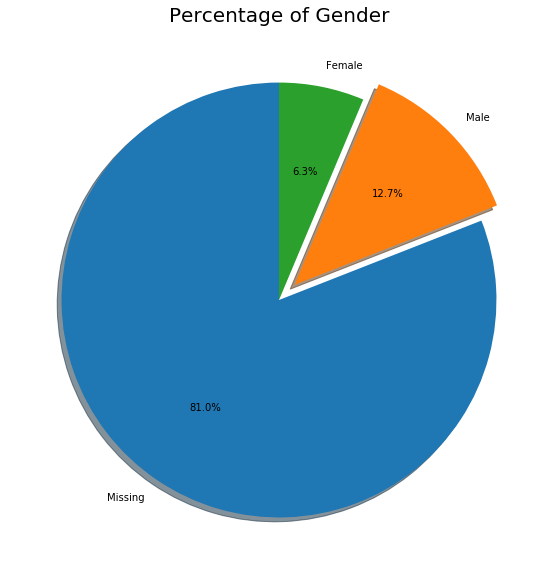

In [13]:
#individual_details.head()
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])


explode = (0, 0.1, 0)


plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

# Spread of Covid-19 over time

In [14]:
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'])
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

spread=pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
#spread.head()

spread['Date'] = spread['Date'].apply(pd.to_datetime)
spread = spread[spread['Date'] > pd.Timestamp(date(2020,1,20))]
india_spread = spread[spread['Country/Region']=='India'].reset_index(drop=True)
india_spread['Active'] = india_spread['Confirmed'] - (india_spread['Deaths'] + india_spread['Recovered'])


# Daily cases
india_spread['Confirmed_diff'] = india_spread['Confirmed'].diff()
india_spread['Death_diff'] = india_spread['Deaths'].diff()
india_spread['Recovered_diff'] = india_spread['Recovered'].diff()

# growth rate of confirmed cases
india_spread['Confirmed_gr'] = np.round(india_spread['Confirmed_diff'].pct_change(), 2)

In [15]:
date_india_spread = india_spread.groupby('Date')['Confirmed','Deaths','Recovered', 'Active'].sum().reset_index()

trace1 = go.Scatter(
                x=date_india_spread['Date'],
                y=date_india_spread['Confirmed'],
                name="Confirmed",
                mode='lines+markers',
                line_color='orange')
trace2 = go.Scatter(
                x=date_india_spread['Date'],
                y=date_india_spread['Deaths'],
                name="Deaths",
                mode='lines+markers',
                line_color='red')

trace3 = go.Scatter(
                x=date_india_spread['Date'],
                y=date_india_spread['Recovered'],
                name="Recovered",
                mode='lines+markers',
                line_color='green')
trace4 = go.Scatter(
                x=date_india_spread['Date'],
                y=date_india_spread['Active'],
                name="Active",
                mode='lines+markers',
                line_color='blue')

layout = go.Layout(template="ggplot2", width=700, height=500, title_text = '<b>Spread of the Coronavirus In India Over Time </b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig = go.Figure(data = [trace1,trace2,trace3, trace4], layout = layout)
fig.show()

# plot daily cases
colors = ['#FFA500']*85
colors[-5] = 'crimson'
fig = px.bar(india_spread, 
             x="Date", y="Confirmed_diff", 
             title='<b>New Confirm Cases Per Day In India</b>', 
             orientation='v', 
             width=700, height=600)
fig.update_traces(marker_color=colors, opacity=0.8)

fig.add_annotation( # add a text callout with arrow
    text="First Lockdown", x='2020-03-24', y=1400, arrowhead=1, showarrow=True
)

fig.add_annotation( # add a text callout with arrow
    text="Extended Lockdown", x='2020-04-14', y=1400, arrowhead=1, showarrow=True
)
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-03-24',
            y0=0,
            x1='2020-03-24',
            y1=1800,
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))

fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-04-14',
            y0=0,
            x1='2020-04-14',
            y1=1800,
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))


fig.update_layout(template = 'plotly_white',font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig.show()



# plot of growth rate of confirmed cases
fig1 = px.scatter(india_spread, 
                 x='Date', 
                  y="Confirmed_gr", 
                  text='Confirmed_gr',
                  range_x=['2020-03-05','2020-04-22'])
fig1.update_traces(marker=dict(size=3,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  marker_color='#4169e1',
                  mode='text+lines+markers',textposition='top center', )

fig1.update_layout(template = 'plotly_white', width=700, height=700, title_text = '<b>Growth percent in number of total<br>COVID-19 cases in India on each day<br>compared to the previous day</b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig1.show()

# Death/Recovery rate

In [16]:
state_details = pd.pivot_table(india_covid_19, values=['Confirmed','Deaths','Cured'], index='State/UnionTerritory', aggfunc='max')
state_details['Recovery Rate'] = round(state_details['Cured'] / state_details['Confirmed'],2)
state_details['Death Rate'] = round(state_details['Deaths'] /state_details['Confirmed'], 2)
state_details = state_details.sort_values(by='Confirmed', ascending= False)
state_details.style.background_gradient(cmap='Reds')

,Confirmed,Cured,Deaths,Recovery Rate,Death Rate
State/UnionTerritory,,,,,
Maharashtra,33053,7688,1198,0.230000,0.040000
Gujarat,11379,4499,659,0.400000,0.060000
Tamil Nadu,11224,4172,78,0.370000,0.010000
Delhi,10054,4485,160,0.450000,0.020000
Rajasthan,5202,2992,131,0.580000,0.030000
Madhya Pradesh,4977,2403,248,0.480000,0.050000
Uttar Pradesh,4259,2441,104,0.570000,0.020000
West Bengal,2677,959,238,0.360000,0.090000
Andhra Pradesh,2407,1456,50,0.600000,0.020000


# Testings

In [17]:
#state_testing.head()
testing=state_testing.groupby('State').sum().reset_index()
#testing.head()
fig = px.bar(testing, 
             x="TotalSamples",
             y="State", 
             orientation='h',
             height=800,
             title='Testing statewise insight')
fig.show()

# Laboratory

In [18]:
fig = px.treemap(ICMR_labs, path=['state','city'],
                  color='city', hover_data=['lab','address'],
                  color_continuous_scale='reds')
fig.show()

In [19]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)
df = pd.DataFrame(list(zip(values, names)), 
               columns =['values', 'names'])
fig = px.bar(df , x="values",y="names",orientation='h',height=1000, title="ICMR Testing Centers in each State")
fig.show()

# Hospital Beds

In [20]:
bed = pd.read_csv('../input/covid19-in-india/HospitalBedsIndia.csv')
bed['Total beds'] = bed.NumPublicBeds_HMIS + bed.NumRuralBeds_NHP18 + bed.NumUrbanBeds_NHP18

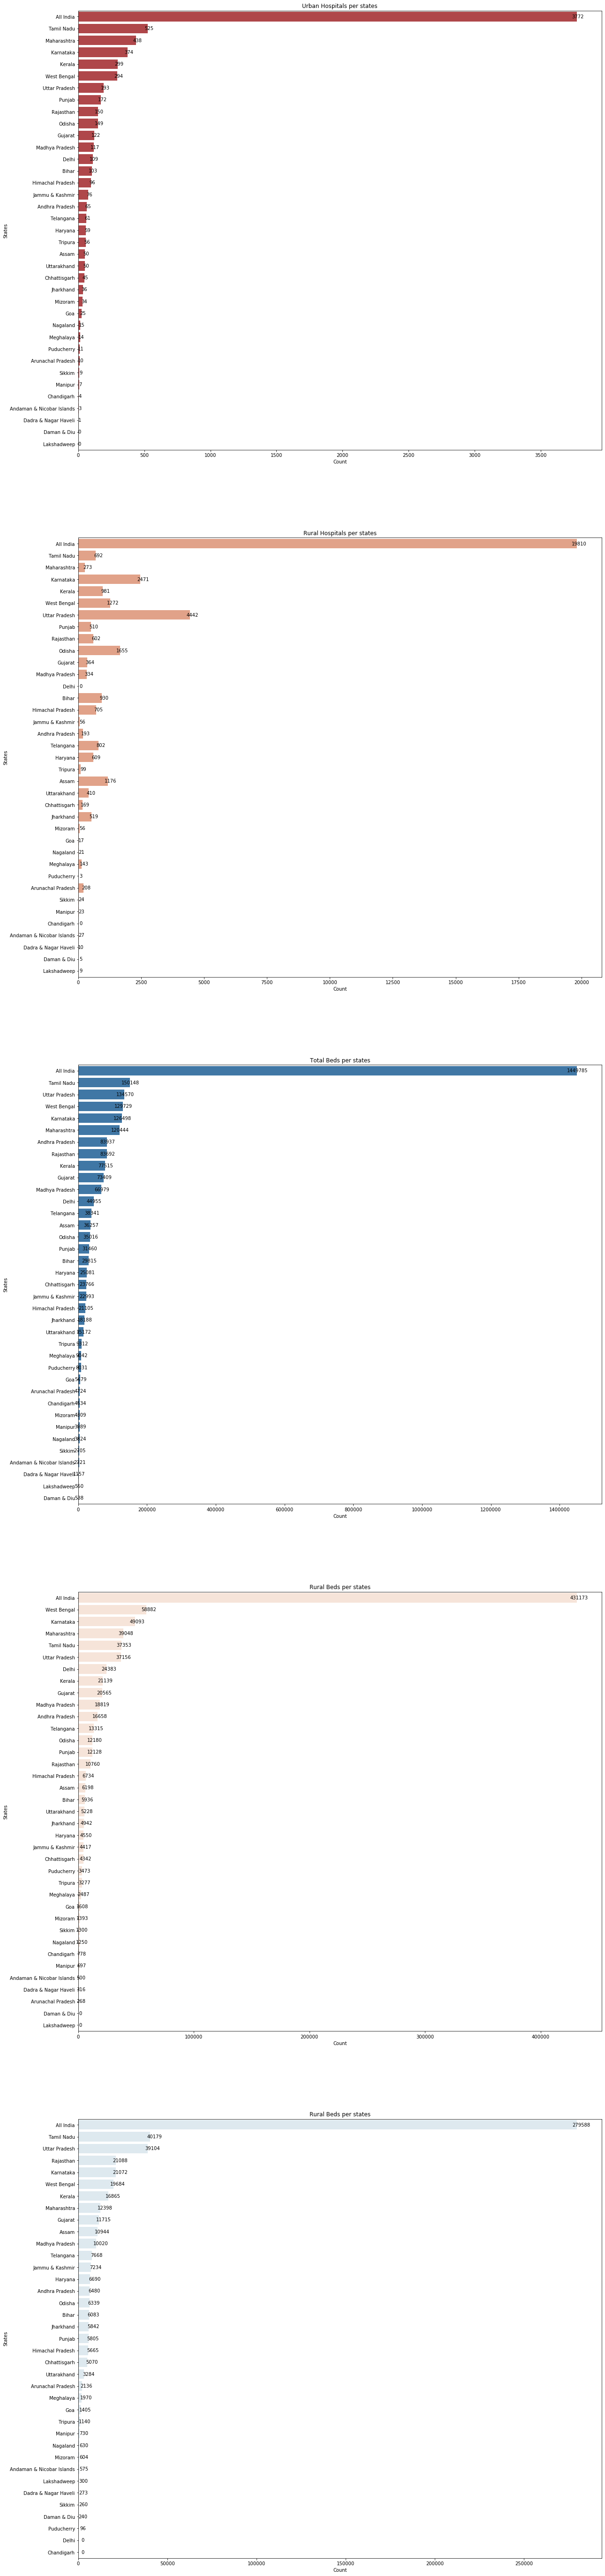

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(20,100))

plt.subplot(5,1,1)
bed=bed.sort_values('NumUrbanHospitals_NHP18', ascending= False)
sns.barplot(data=bed,y='State/UT',x='NumUrbanHospitals_NHP18',color=sns.color_palette('RdBu')[0])
plt.title('Urban Hospitals per states')
plt.xlabel('Count')
plt.ylabel('States')
for i in range(bed.shape[0]):
    count = bed.iloc[i]['NumUrbanHospitals_NHP18']
    plt.text(count+10,i,count,ha='center',va='center')


plt.subplot(5,1,2)
beds=bed.sort_values('NumRuralHospitals_NHP18', ascending= False)
sns.barplot(data=bed,y='State/UT',x='NumRuralHospitals_NHP18',color=sns.color_palette('RdBu')[1])
plt.title('Rural Hospitals per states')
plt.xlabel('Count')
plt.ylabel('States')
for i in range(bed.shape[0]):
    count = bed.iloc[i]['NumRuralHospitals_NHP18']
    plt.text(count+100,i,count,ha='center',va='center')
    
    
plt.subplot(5,1,3)
Beds=bed.sort_values('Total beds', ascending= False)
sns.barplot(data=Beds,y='State/UT',x='Total beds',color=sns.color_palette('RdBu')[5])
plt.title('Total Beds per states')
plt.xlabel('Count')
plt.ylabel('States')
for i in range(Beds.shape[0]):
    count = Beds.iloc[i]['Total beds']
    plt.text(count+1500,i,count,ha='center',va='center')
    
plt.subplot(5,1,4)
hospitalBeds=bed.sort_values('NumUrbanBeds_NHP18', ascending= False)
sns.barplot(data=hospitalBeds,y='State/UT',x='NumUrbanBeds_NHP18',color=sns.color_palette('RdBu')[2])
plt.title('Rural Beds per states')
plt.xlabel('Count')
plt.ylabel('States')
for i in range(hospitalBeds.shape[0]):
    count = hospitalBeds.iloc[i]['NumUrbanBeds_NHP18']
    plt.text(count+2000,i,count,ha='center',va='center')
    
    
plt.subplot(5,1,5)
hospitalBeds=bed.sort_values('NumRuralBeds_NHP18', ascending= False)
sns.barplot(data=hospitalBeds,y='State/UT',x='NumRuralBeds_NHP18',color=sns.color_palette('RdBu')[3])
plt.title('Rural Beds per states')
plt.xlabel('Count')
plt.ylabel('States')
for i in range(hospitalBeds.shape[0]):
    count = hospitalBeds.iloc[i]['NumRuralBeds_NHP18']
    plt.text(count+2500,i,count,ha='center',va='center')

plt.show()
plt.tight_layout()

# Training with world model

In [22]:
train=pd.read_csv('../input/covid19all1/covid-19-all.csv')
train.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,China,Anhui,31.8257,117.2264,1.0,NaN,NaN,2020-01-22
1,China,Beijing,40.1824,116.4142,14.0,NaN,NaN,2020-01-22
2,China,Chongqing,30.0572,107.8740,6.0,NaN,NaN,2020-01-22
3,China,Fujian,26.0789,117.9874,1.0,NaN,NaN,2020-01-22
4,China,Gansu,37.8099,101.0583,NaN,NaN,NaN,2020-01-22


In [23]:
india_df = train[train['Country/Region']=='India'].groupby('Date')['Confirmed','Deaths'].sum().reset_index()
india_df

,Date,Confirmed,Deaths
0,2020-01-30,1.0,0.0
1,2020-01-31,1.0,0.0
2,2020-02-01,1.0,0.0
3,2020-02-02,2.0,0.0
4,2020-02-03,3.0,0.0
...,...,...,...
88,2020-04-27,29451.0,939.0
89,2020-04-28,31324.0,1008.0
90,2020-04-29,33062.0,1079.0
91,2020-04-30,34863.0,1154.0


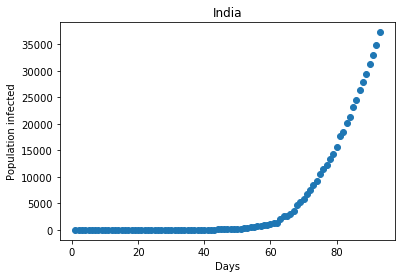

In [24]:
india_df['day_count'] = list(range(1,len(india_df)+1))


#india_df.Confirmed
#india_df.Confirmed.shift(1)

india_df['rate']=(india_df.Confirmed-india_df.Confirmed.shift(1))/(india_df.Confirmed)
india_df['increase']=(india_df.Confirmed-india_df.Confirmed.shift(1))

ydata = india_df.Confirmed
xdata = india_df.day_count

plt.plot(xdata, ydata, 'o')
plt.title("India")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

# Sigmoid Model

In [25]:
in_df = train[train['Country/Region']=='India'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
in_df['Active']=in_df['Confirmed']-in_df['Deaths']-in_df['Recovered']
in_df = in_df[in_df.Active>=100]

In [26]:
from scipy.optimize import curve_fit
import pylab
from datetime import timedelta

in_df['day_count'] = list(range(1,len(in_df)+1))
in_df['increase'] = (in_df.Active-in_df.Active.shift(1))
in_df['rate'] = (in_df.Active-in_df.Active.shift(1))/in_df.Active

In [27]:
def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y

xdata = np.array(list(in_df.day_count)[::2])
ydata = np.array(list(in_df.Active)[::2])

population=1.332*10**9
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[population,6,100.]))
print(popt)

[6.66e+08 3.00e+00 5.00e+01]


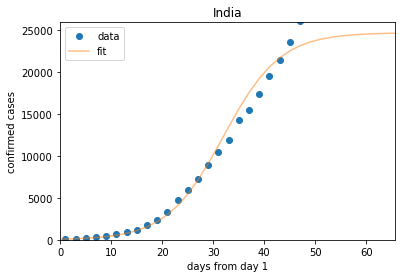

model start date: 46
model fitted max Active at: 24641
model sigmoidal coefficient is: 0.18
model curve stop steepening, start flattening by day: 32
model curve flattens by day: 64


,Date,Confirmed,Deaths,Recovered,Active,day_count,increase,rate
46,2020-03-16,119.0,2.0,13.0,104.0,1,NaN,NaN
47,2020-03-17,142.0,3.0,14.0,125.0,2,21.0,0.168000
48,2020-03-18,156.0,3.0,14.0,139.0,3,14.0,0.100719
49,2020-03-19,194.0,4.0,15.0,175.0,4,36.0,0.205714
50,2020-03-20,244.0,5.0,20.0,219.0,5,44.0,0.200913
51,2020-03-21,330.0,4.0,23.0,303.0,6,84.0,0.277228
52,2020-03-22,396.0,7.0,24.0,365.0,7,62.0,0.169863
53,2020-03-23,499.0,10.0,34.0,455.0,8,90.0,0.197802
54,2020-03-24,536.0,10.0,40.0,486.0,9,31.0,0.063786
55,2020-03-25,657.0,12.0,43.0,602.0,10,116.0,0.192691


In [28]:
est_a = 24641
est_b = 0.18
est_c = 32
x = np.linspace(-1, in_df.day_count.max()+50, 50)
y = sigmoid(x,est_a,est_b,est_c)
pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit',alpha = 0.5)
pylab.ylim(-0.05, est_a*1.05)
pylab.xlim(-0.05, est_c*2.05)
pylab.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('India')
pylab.show()


print('model start date:',in_df[in_df.day_count==1].index[0])
print('model fitted max Active at:',int(est_a))
print('model sigmoidal coefficient is:',round(est_b,3))
print('model curve stop steepening, start flattening by day:',int(est_c))
print('model curve flattens by day:',int(est_c)*2)
display(in_df)

# Logistic Model

In [29]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0))) + 1
p0 = (0,0,0)

def plot_logistic_fit_data(date_india_spread, title, p0=p0):
    date_india_spread['x'] = np.arange(len(date_india_spread)) + 1
    date_india_spread['y'] = date_india_spread['Confirmed']
    
    
    x = date_india_spread['x']
    y = date_india_spread['y']

    c2 = scipy.optimize.curve_fit(logistic,  x,  y,  p0=p0 )
    
    popt, pcov = c2
    
    
    x = range(1,date_india_spread.shape[0] + int(popt[2]))
    y_fit = logistic(x, *popt)
    
    p_df = pd.DataFrame()
    p_df['x'] = x
    p_df['y'] = y_fit.astype(int)
    
    print("Predicted L (the maximum number of confirmed cases): " + str(int(popt[0])))
    print("Predicted k (growth rate): " + str(float(popt[1])))
    print("Predicted x0 (the day of the inflexion): " + str(int(popt[2])) + "")
    
    x0 = int(popt[2])
    
    
    traceC = go.Scatter(
        x=date_india_spread['x'], y=date_india_spread['y'],
        name="Confirmed",
        marker=dict(color="#FF4500"),
        mode = "markers+lines",
        text=date_india_spread['Confirmed'],
    )

    traceP = go.Scatter(
        x=p_df['x'], y=p_df['y'],
        name="Predicted",
        marker=dict(color="blue"),
        mode = "lines",
        text=p_df['y'],
    )
    
    trace_x0 = go.Scatter(
        x = [x0, x0], y = [0, p_df.loc[p_df['x']==x0,'y'].values[0]],
        name = "X0 - Inflexion point",
        marker=dict(color="black"),
        mode = "lines",
        text = "X0 - Inflexion point"
    )

    data = [traceC, traceP, trace_x0]
    
    
    layout = go.Layout(template = 'plotly_white',width=700, height=500, title = 'Cumulative Conformed cases and logistic curve projection',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'),
                  xaxis = dict(title = 'Day since first case', showticklabels=True), 
                  yaxis = dict(title = 'Number of cases'),
                  hovermode = 'closest'
         )
    
    
        
    fig = go.Figure(data = data, layout = layout)
    fig.show()
    
    

L = 3308643
k = 0.25
x0 = 100
p0 = (L, k, x0)
plot_logistic_fit_data(date_india_spread, 'India')

Predicted L (the maximum number of confirmed cases): 174683
Predicted k (growth rate): 0.08752432833586708
Predicted x0 (the day of the inflexion): 115


# Fitting Linear, Polynomial and SVM Regression Models(World)

# Linear Regression Model for Confirmed Cases

In [30]:
data = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')

data["Date"]=pd.to_datetime(data["Date"])
datewise=data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days
datewise.head()

,Confirmed,Recovered,Deaths,Days Since
Date,,,,
2020-01-22,555,28,17,0
2020-01-23,654,30,18,1
2020-01-24,941,36,26,2
2020-01-25,1434,39,42,3
2020-01-26,2118,52,56,4


In [31]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [32]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [33]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  1333986.3921440754


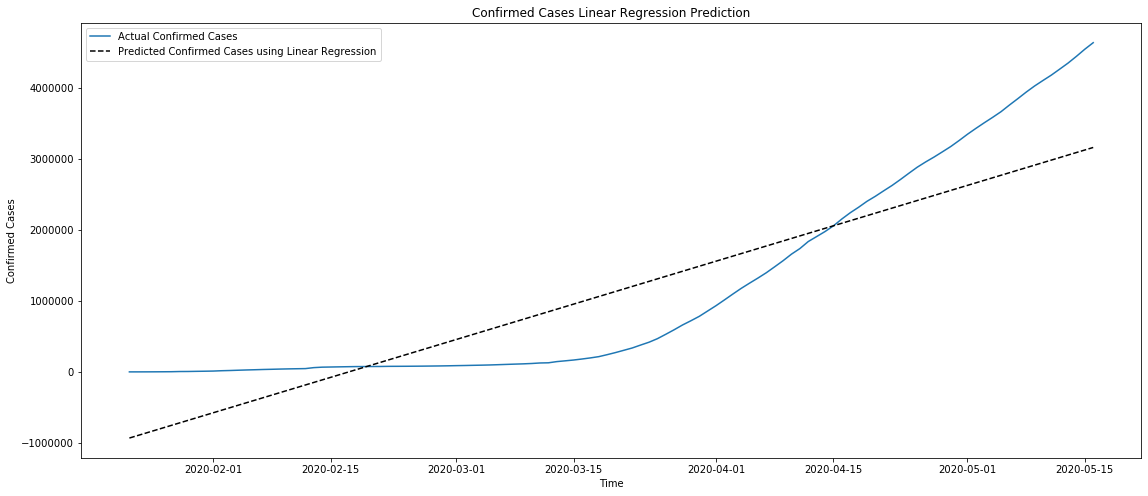

In [34]:
plt.figure(figsize=(19,8))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Linear Regression Prediction")
plt.legend()

# Polynomial Regression for Confirmed Cases

In [35]:
poly = PolynomialFeatures(degree = 2)

In [36]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [37]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [38]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  171445.9305558849


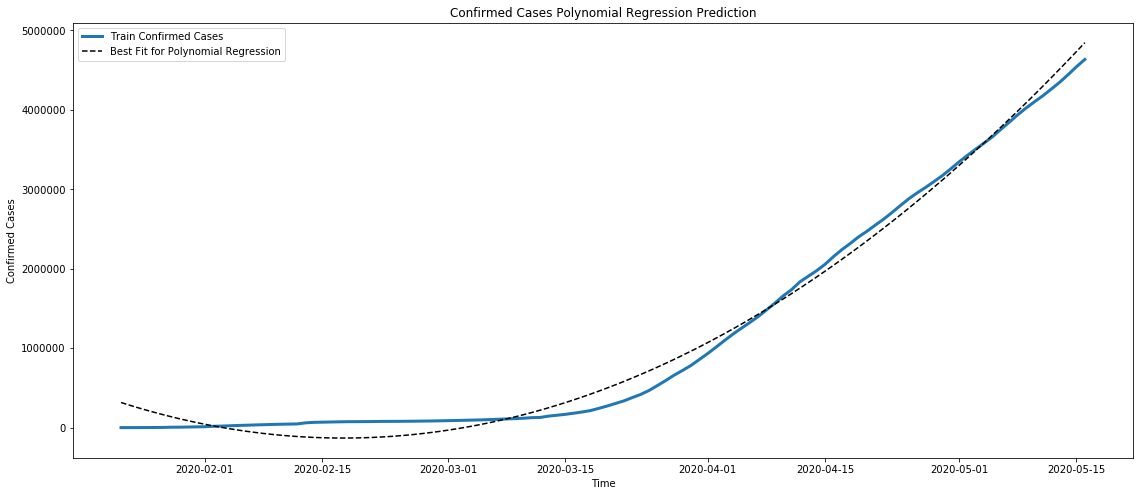

In [39]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(19,8))
predictions_poly=linreg.predict(comp_data)
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,predictions_poly, linestyle='--',label="Best Fit for Polynomial Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Polynomial Regression Prediction")
plt.legend()

In [40]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

# SVM Model Regressor for Confirmed Cases

In [41]:
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [43]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  449529.86262025463


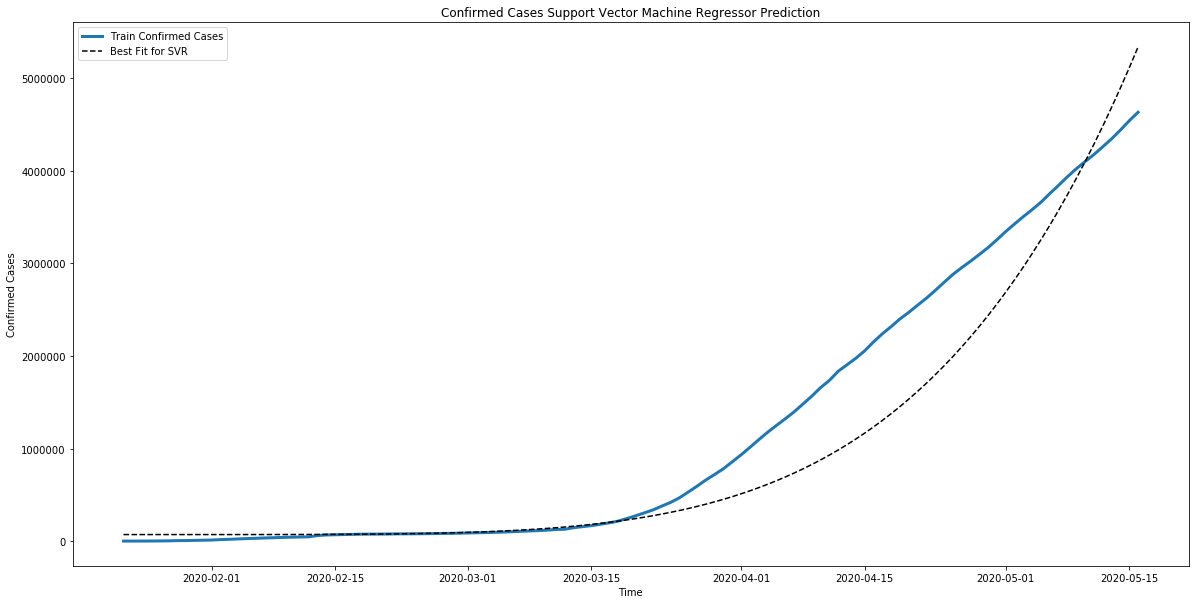

In [44]:
plt.figure(figsize=(20,10))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,prediction_svm, linestyle='--',label="Best Fit for SVR",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Support Vector Machine Regressor Prediction")
plt.legend()

# Random Forest Regressor for Confirmed Cases

In [45]:
forest_reg = RandomForestRegressor(n_estimators=5, random_state=42)
forest_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [46]:
prediction_valid_forestreg=forest_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_forestreg)))
print("Root Mean Square Error for Forest Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_forestreg)))

Root Mean Square Error for Forest Regression:  351725.54816101526


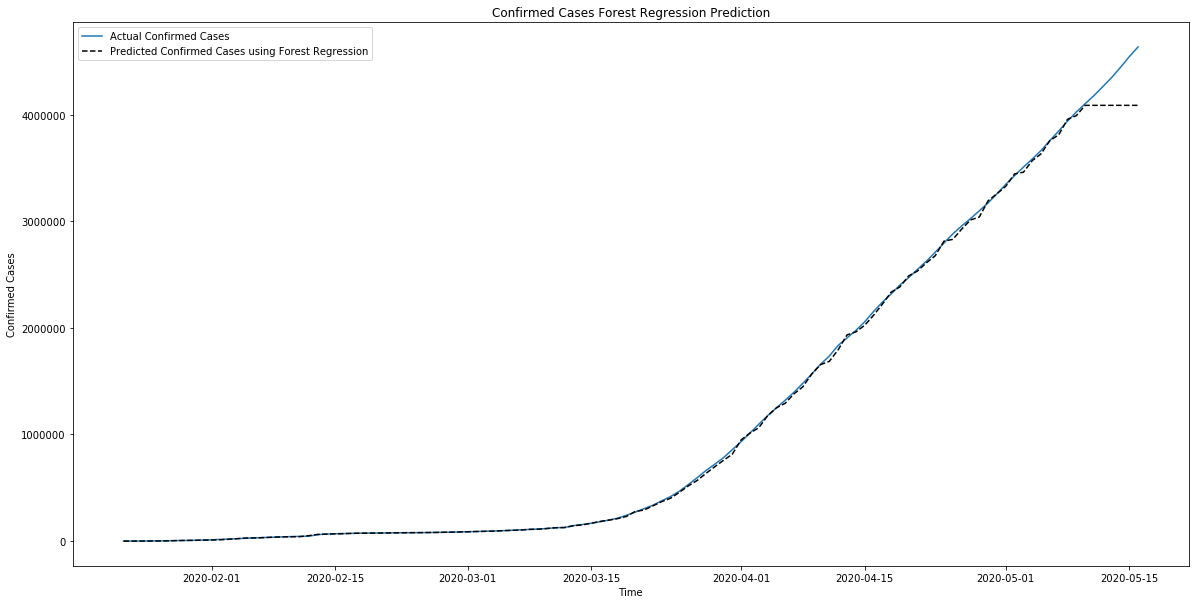

In [47]:
plt.figure(figsize=(20,10))
prediction_forestreg=forest_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_forestreg, linestyle='--',label="Predicted Confirmed Cases using Forest Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Forest Regression Prediction")
plt.legend()

In [48]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [49]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-05-17,3194781.610969,4958124.059491,5573183.835152
1,2020-05-18,3230344.826225,5072510.080665,5814468.184793
2,2020-05-19,3265908.041481,5188167.437419,6064144.098063
3,2020-05-20,3301471.256736,5305096.129751,6322428.582237
4,2020-05-21,3337034.471992,5423296.157663,6589542.353985
5,2020-05-22,3372597.687248,5542767.521155,6865709.870801
6,2020-05-23,3408160.902504,5663510.220225,7151159.362443
7,2020-05-24,3443724.117760,5785524.254875,7446122.862368
8,2020-05-25,3479287.333016,5908809.625105,7750836.239166
9,2020-05-26,3514850.548272,6033366.330913,8065539.227997
